In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class ContrastiveAutoencoder(nn.Module):
    """
    Autoencoder with contrastive learning capability for network anomaly detection
    """
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], sparsity_weight=1e-4):
        super(ContrastiveAutoencoder, self).__init__()

        self.input_dim = input_dim
        self.sparsity_weight = sparsity_weight

        # Encoder
        encoder_layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder (reverse of encoder)
        decoder_layers = []
        hidden_dims_reverse = hidden_dims[::-1][1:] + [input_dim]

        for hidden_dim in hidden_dims_reverse:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU() if hidden_dim != input_dim else nn.Identity()
            ])
            prev_dim = hidden_dim

        self.decoder = nn.Sequential(*decoder_layers)

        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[-1], hidden_dims[-1] // 2)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

    def get_projection(self, x):
        z = self.encode(x)
        return self.projection_head(z)

    def sparsity_loss(self, z):
        """L1 sparsity penalty on latent representation"""
        return torch.mean(torch.abs(z))

In [ ]:
class NetworkTrafficDataset(Dataset):
    """Custom dataset for network traffic data"""
    def __init__(self, data, labels=None, transform=None):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels) if labels is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        if self.labels is not None:
            return sample, self.labels[idx]
        return sample

In [ ]:
class AnomalyDetector:
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], device='cpu'):
        self.device = device
        self.model = ContrastiveAutoencoder(input_dim, hidden_dims).to(device)
        self.scaler = StandardScaler()
        self.threshold = None
        self.training_history = {
            'train_loss': [],
            'val_loss': [],
            'contrastive_loss': [],
            'reconstruction_loss': [],
            'sparsity_loss': []
        }

    def contrastive_loss(self, z_i, z_j, temperature=0.07):
        """InfoNCE contrastive loss"""
        batch_size = z_i.shape[0]

        # Normalize features
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Compute similarity matrix
        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = torch.matmul(representations, representations.T) / temperature

        # Create labels for positive pairs
        labels = torch.cat([torch.arange(batch_size) + batch_size,
                           torch.arange(batch_size)], dim=0).to(self.device)

        # Mask out self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(self.device)
        similarity_matrix.masked_fill_(mask, -9e15)

        # Compute InfoNCE loss
        loss = F.cross_entropy(similarity_matrix, labels)
        return loss

    def create_contrastive_pairs(self, x, augmentation_noise=0.1):
        """Create augmented pairs for contrastive learning"""
        # Add noise as augmentation
        x_aug = x + torch.randn_like(x) * augmentation_noise
        return x, x_aug

    def fit(self, train_data, val_data=None, epochs=100, batch_size=128,
            lr=1e-3, patience=10, contrastive_weight=0.1):
        """Train the autoencoder with contrastive pretraining"""

        # Prepare data
        train_dataset = NetworkTrafficDataset(train_data)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        if val_data is not None:
            val_dataset = NetworkTrafficDataset(val_data)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        # Early stopping
        best_val_loss = float('inf')
        patience_counter = 0

        print("Starting training...")
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_recon_loss = 0.0
            train_contrastive_loss = 0.0
            train_sparsity_loss = 0.0

            for batch_idx, batch_data in enumerate(train_loader):
                batch_data = batch_data.to(self.device)

                # Create contrastive pairs
                x_orig, x_aug = self.create_contrastive_pairs(batch_data)

                optimizer.zero_grad()

                # Forward pass
                x_recon, z = self.model(x_orig)
                x_aug_recon, z_aug = self.model(x_aug)

                # Reconstruction loss
                recon_loss = F.mse_loss(x_recon, x_orig)

                # Contrastive loss
                proj_orig = self.model.get_projection(x_orig)
                proj_aug = self.model.get_projection(x_aug)
                contrastive_loss = self.contrastive_loss(proj_orig, proj_aug)

                # Sparsity loss
                sparsity_loss = self.model.sparsity_loss(z)

                # Total loss
                total_loss = (recon_loss +
                            contrastive_weight * contrastive_loss +
                            self.model.sparsity_weight * sparsity_loss)

                total_loss.backward()
                optimizer.step()

                train_loss += total_loss.item()
                train_recon_loss += recon_loss.item()
                train_contrastive_loss += contrastive_loss.item()
                train_sparsity_loss += sparsity_loss.item()

            # Validation phase
            val_loss = 0.0
            if val_data is not None:
                self.model.eval()
                with torch.no_grad():
                    for batch_data in val_loader:
                        batch_data = batch_data.to(self.device)
                        x_recon, z = self.model(batch_data)
                        val_loss += F.mse_loss(x_recon, batch_data).item()
                val_loss /= len(val_loader)

            # Update learning rate
            if val_data is not None:
                scheduler.step(val_loss)

            # Record training history
            self.training_history['train_loss'].append(train_loss / len(train_loader))
            self.training_history['reconstruction_loss'].append(train_recon_loss / len(train_loader))
            self.training_history['contrastive_loss'].append(train_contrastive_loss / len(train_loader))
            self.training_history['sparsity_loss'].append(train_sparsity_loss / len(train_loader))

            if val_data is not None:
                self.training_history['val_loss'].append(val_loss)

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save best model
                    torch.save(self.model.state_dict(), 'best_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

            if (epoch + 1) % 10 == 0:
                if val_data is not None:
                    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.6f}, '
                          f'Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
                else:
                    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.6f}')

        # Load best model
        if val_data is not None:
            self.model.load_state_dict(torch.load('best_model.pth'))

        print("Training completed!")

    def compute_reconstruction_errors(self, data):
        """Compute reconstruction errors for anomaly detection"""
        self.model.eval()
        dataset = NetworkTrafficDataset(data)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

        errors = []
        with torch.no_grad():
            for batch_data in dataloader:
                batch_data = batch_data.to(self.device)
                x_recon, _ = self.model(batch_data)
                error = torch.mean((batch_data - x_recon) ** 2, dim=1)
                errors.extend(error.cpu().numpy())

        return np.array(errors)

    def set_threshold(self, normal_data, percentile=95):
        """Set anomaly threshold based on normal data reconstruction errors"""
        errors = self.compute_reconstruction_errors(normal_data)
        self.threshold = np.percentile(errors, percentile)
        print(f"Anomaly threshold set to: {self.threshold:.6f}")
        return self.threshold

    def predict(self, data):
        """Predict anomalies based on reconstruction error threshold"""
        errors = self.compute_reconstruction_errors(data)
        predictions = (errors > self.threshold).astype(int)
        return predictions, errors

    def visualize_training(self):
        """Visualize training progress"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training Progress', fontsize=16)

        # Training and validation loss
        axes[0, 0].plot(self.training_history['train_loss'], label='Train Loss', color='blue')
        if self.training_history['val_loss']:
            axes[0, 0].plot(self.training_history['val_loss'], label='Val Loss', color='red')
        axes[0, 0].set_title('Overall Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Component losses
        axes[0, 1].plot(self.training_history['reconstruction_loss'], label='Reconstruction', color='green')
        axes[0, 1].plot(self.training_history['contrastive_loss'], label='Contrastive', color='orange')
        axes[0, 1].plot(self.training_history['sparsity_loss'], label='Sparsity', color='purple')
        axes[0, 1].set_title('Component Losses')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Reconstruction loss detailed view
        axes[1, 0].plot(self.training_history['reconstruction_loss'], color='green', linewidth=2)
        axes[1, 0].set_title('Reconstruction Loss (Detailed)')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('MSE Loss')
        axes[1, 0].grid(True, alpha=0.3)

        # Loss ratios
        recon_losses = np.array(self.training_history['reconstruction_loss'])
        contrastive_losses = np.array(self.training_history['contrastive_loss'])
        axes[1, 1].plot(contrastive_losses / (recon_losses + 1e-8), color='red', linewidth=2)
        axes[1, 1].set_title('Contrastive/Reconstruction Loss Ratio')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Ratio')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def visualize_reconstruction_errors(self, normal_data, anomaly_data):
        """Visualize reconstruction error distributions"""
        normal_errors = self.compute_reconstruction_errors(normal_data)
        anomaly_errors = self.compute_reconstruction_errors(anomaly_data)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Histogram comparison
        axes[0].hist(normal_errors, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
        axes[0].hist(anomaly_errors, bins=50, alpha=0.7, label='Anomaly', color='red', density=True)
        if self.threshold:
            axes[0].axvline(self.threshold, color='black', linestyle='--',
                           label=f'Threshold: {self.threshold:.4f}')
        axes[0].set_xlabel('Reconstruction Error')
        axes[0].set_ylabel('Density')
        axes[0].set_title('Error Distribution Comparison')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Box plot
        data_to_plot = [normal_errors, anomaly_errors]
        axes[1].boxplot(data_to_plot, labels=['Normal', 'Anomaly'])
        if self.threshold:
            axes[1].axhline(self.threshold, color='red', linestyle='--',
                           label=f'Threshold: {self.threshold:.4f}')
        axes[1].set_ylabel('Reconstruction Error')
        axes[1].set_title('Error Distribution Box Plot')
        axes[1].grid(True, alpha=0.3)

        # Cumulative distribution
        sorted_normal = np.sort(normal_errors)
        sorted_anomaly = np.sort(anomaly_errors)
        axes[2].plot(sorted_normal, np.linspace(0, 1, len(sorted_normal)),
                    label='Normal', color='blue', linewidth=2)
        axes[2].plot(sorted_anomaly, np.linspace(0, 1, len(sorted_anomaly)),
                    label='Anomaly', color='red', linewidth=2)
        if self.threshold:
            axes[2].axvline(self.threshold, color='black', linestyle='--',
                           label=f'Threshold: {self.threshold:.4f}')
        axes[2].set_xlabel('Reconstruction Error')
        axes[2].set_ylabel('Cumulative Probability')
        axes[2].set_title('Cumulative Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def evaluate_performance(self, test_data, test_labels):
        """Evaluate model performance with various metrics"""
        predictions, errors = self.predict(test_data)

        # Classification metrics
        from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

        accuracy = accuracy_score(test_labels, predictions)
        precision = precision_score(test_labels, predictions)
        recall = recall_score(test_labels, predictions)
        f1 = f1_score(test_labels, predictions)
        auc_score = roc_auc_score(test_labels, errors)

        print("Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc_score:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(test_labels, predictions)

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')

        # ROC Curve
        fpr, tpr, _ = roc_curve(test_labels, errors)
        axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc_score:.3f})')
        axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend(loc="lower right")
        axes[1].grid(True, alpha=0.3)

        # Precision-Recall curve
        from sklearn.metrics import precision_recall_curve, average_precision_score
        precision_curve, recall_curve, _ = precision_recall_curve(test_labels, errors)
        avg_precision = average_precision_score(test_labels, errors)

        axes[2].plot(recall_curve, precision_curve, color='green', lw=2,
                    label=f'PR (AP = {avg_precision:.3f})')
        axes[2].set_xlabel('Recall')
        axes[2].set_ylabel('Precision')
        axes[2].set_title('Precision-Recall Curve')
        axes[2].legend(loc="lower left")
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_score,
            'avg_precision': avg_precision
        }


In [ ]:
def load_and_preprocess_cicids2017(file_path, sample_size=None):
    """
    Load and preprocess CICIDS 2017 dataset
    Note: You'll need to download the dataset from:
    https://www.unb.ca/cic/datasets/ids-2017.html
    """
    try:
        # Load the dataset
        print("Loading CICIDS 2017 dataset...")
        df = pd.read_csv(file_path)

        if sample_size:
            df = df.sample(n=min(sample_size, len(df)), random_state=42)

        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")

        # Handle missing values
        df = df.dropna()

        # Encode categorical features
        label_encoders = {}
        for column in df.select_dtypes(include=['object']).columns:
            if column != 'Label':  # Assuming 'Label' is the target column
                le = LabelEncoder()
                df[column] = le.fit_transform(df[column].astype(str))
                label_encoders[column] = le

        # Separate features and labels
        # Adjust column name based on your dataset
        label_column = 'Label'  # or ' Label' with space, check your dataset
        if label_column in df.columns:
            X = df.drop(columns=[label_column]).values
            y = (df[label_column] != 'BENIGN').astype(int).values  # Binary: 0=benign, 1=attack
        else:
            print("Warning: Label column not found. Using unsupervised approach.")
            X = df.values
            y = None

        print(f"Features shape: {X.shape}")
        if y is not None:
            print(f"Labels shape: {y.shape}")
            print(f"Anomaly ratio: {np.mean(y):.4f}")

        return X, y, label_encoders

    except FileNotFoundError:
        print("CICIDS 2017 dataset not found. Generating synthetic data for demonstration...")
        return generate_synthetic_network_data()

In [ ]:
def generate_synthetic_network_data(n_samples=10000, n_features=20, anomaly_ratio=0.05):
    """Generate synthetic network traffic data for demonstration"""
    print("Generating synthetic network traffic data...")

    np.random.seed(42)

    # Normal traffic (multivariate normal distribution)
    n_normal = int(n_samples * (1 - anomaly_ratio))
    normal_data = np.random.multivariate_normal(
        mean=np.zeros(n_features),
        cov=np.eye(n_features),
        size=n_normal
    )

    # Anomalous traffic (shifted mean and different covariance)
    n_anomaly = n_samples - n_normal
    anomaly_mean = np.random.uniform(-3, 3, n_features)
    anomaly_cov = np.eye(n_features) * np.random.uniform(0.5, 2.0, n_features)
    anomaly_data = np.random.multivariate_normal(
        mean=anomaly_mean,
        cov=anomaly_cov,
        size=n_anomaly
    )

    # Combine data
    X = np.vstack([normal_data, anomaly_data])
    y = np.hstack([np.zeros(n_normal), np.ones(n_anomaly)])

    # Shuffle
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]

    print(f"Generated {n_samples} samples with {n_features} features")
    print(f"Anomaly ratio: {anomaly_ratio:.4f}")

    return X, y, {}

def main():
    """Main execution function"""
    print("Network Traffic Anomaly Detection with PyTorch")
    print("=" * 50)

    # Check for CUDA
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load and preprocess data
    # Replace with your actual CICIDS 2017 file path
    file_path = "path/to/your/cicids2017.csv"
    X, y, label_encoders = load_and_preprocess_cicids2017(file_path, sample_size=50000)

    # Split data
    if y is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
    else:
        X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
        X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
        y_train = y_val = y_test = None

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Initialize detector
    detector = AnomalyDetector(
        input_dim=X_train_scaled.shape[1],
        hidden_dims=[128, 64, 32],
        device=device
    )

    # Train the model
    print("\nTraining autoencoder...")
    detector.fit(
        train_data=X_train_scaled,
        val_data=X_val_scaled,
        epochs=100,
        batch_size=256,
        lr=1e-3,
        patience=15,
        contrastive_weight=0.1
    )

    # Visualize training progress
    print("\nVisualizing training progress...")
    detector.visualize_training()

    # Set threshold using normal data (assuming label 0 is normal)
    if y_train is not None:
        normal_indices = y_train == 0
        normal_data = X_train_scaled[normal_indices]
        detector.set_threshold(normal_data, percentile=95)
    else:
        detector.set_threshold(X_train_scaled, percentile=95)

    # Evaluate on test set
    if y_test is not None:
        print("\nEvaluating model performance...")
        metrics = detector.evaluate_performance(X_test_scaled, y_test)

        # Visualize reconstruction errors
        normal_test = X_test_scaled[y_test == 0]
        anomaly_test = X_test_scaled[y_test == 1]

        if len(normal_test) > 0 and len(anomaly_test) > 0:
            print("\nVisualizing reconstruction errors...")
            detector.visualize_reconstruction_errors(normal_test, anomaly_test)
    else:
        print("\nNo labels available for evaluation. Computing reconstruction errors...")
        predictions, errors = detector.predict(X_test_scaled)
        print(f"Predicted anomalies: {np.sum(predictions)} / {len(predictions)} "
              f"({np.mean(predictions)*100:.2f}%)")

    print("\nAnomaly detection analysis completed!")


Network Traffic Anomaly Detection with PyTorch
Using device: cuda
Loading CICIDS 2017 dataset...
CICIDS 2017 dataset not found. Generating synthetic data for demonstration...
Generating synthetic network traffic data...
Generated 10000 samples with 20 features
Anomaly ratio: 0.0500

Training autoencoder...
Starting training...
Epoch [10/100], Train Loss: 0.907961, Val Loss: 0.600874, LR: 0.001000
Epoch [20/100], Train Loss: 0.833390, Val Loss: 0.573471, LR: 0.001000
Epoch [30/100], Train Loss: 0.797360, Val Loss: 0.563125, LR: 0.001000
Epoch [40/100], Train Loss: 0.758319, Val Loss: 0.539907, LR: 0.001000
Epoch [50/100], Train Loss: 0.723433, Val Loss: 0.511236, LR: 0.001000
Epoch [60/100], Train Loss: 0.699570, Val Loss: 0.500999, LR: 0.001000
Epoch [70/100], Train Loss: 0.685903, Val Loss: 0.498875, LR: 0.001000
Epoch [80/100], Train Loss: 0.671113, Val Loss: 0.485164, LR: 0.001000
Epoch [90/100], Train Loss: 0.659318, Val Loss: 0.481208, LR: 0.001000
Epoch [100/100], Train Loss: 0.6

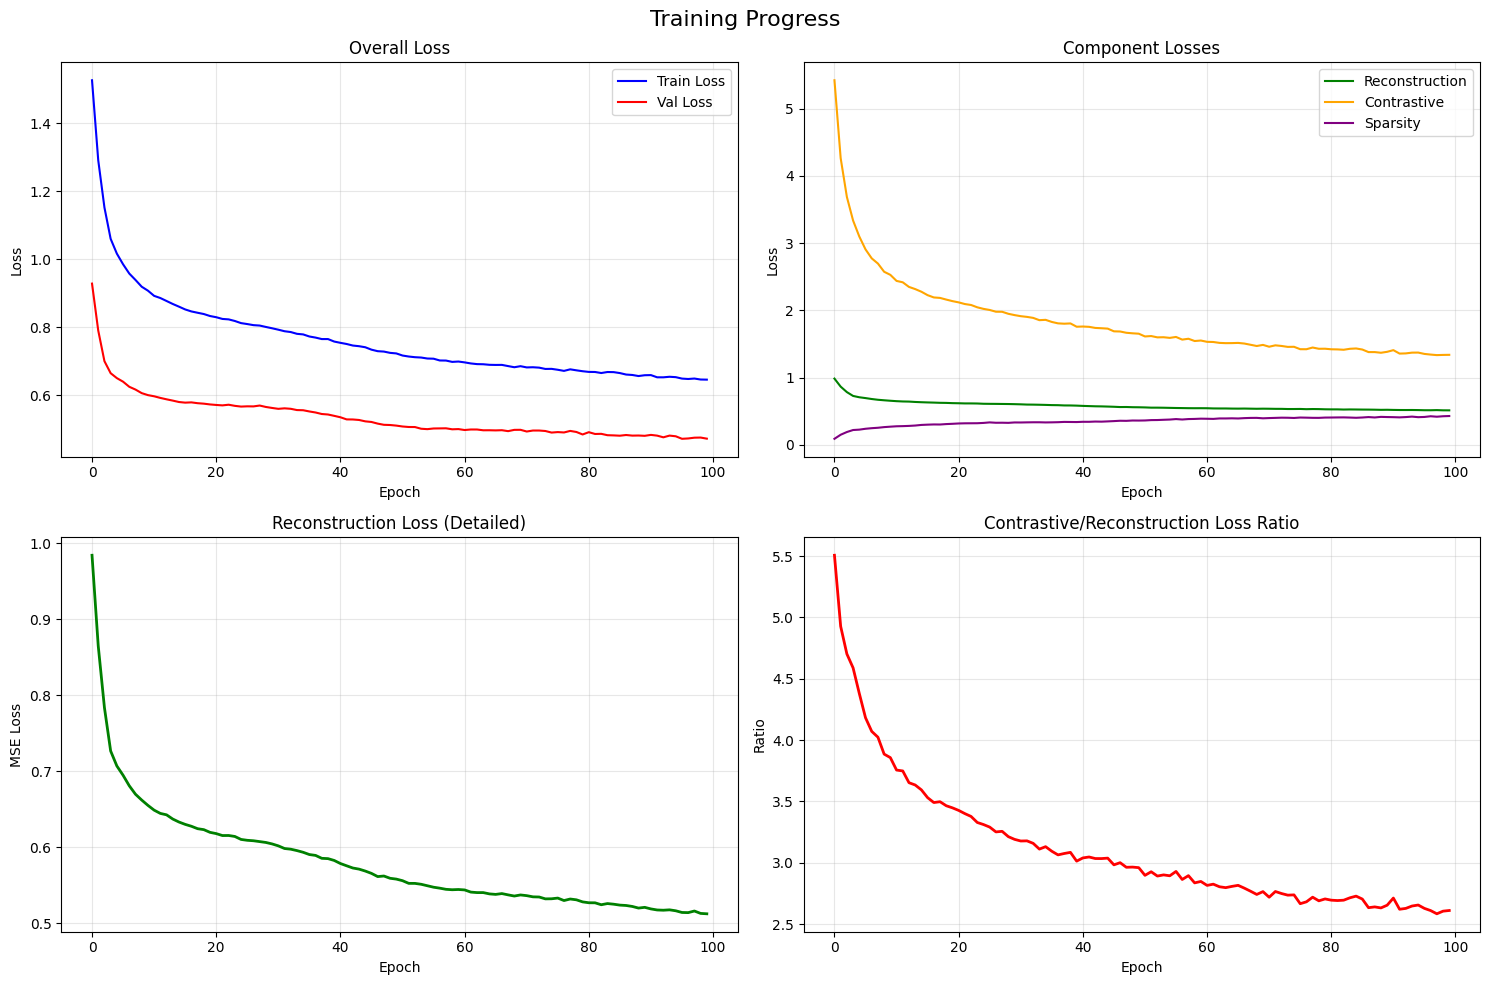

Anomaly threshold set to: 0.772322

Evaluating model performance...
Performance Metrics:
Accuracy: 0.9115
Precision: 0.2638
Recall: 0.4300
F1-Score: 0.3270
AUC-ROC: 0.8286


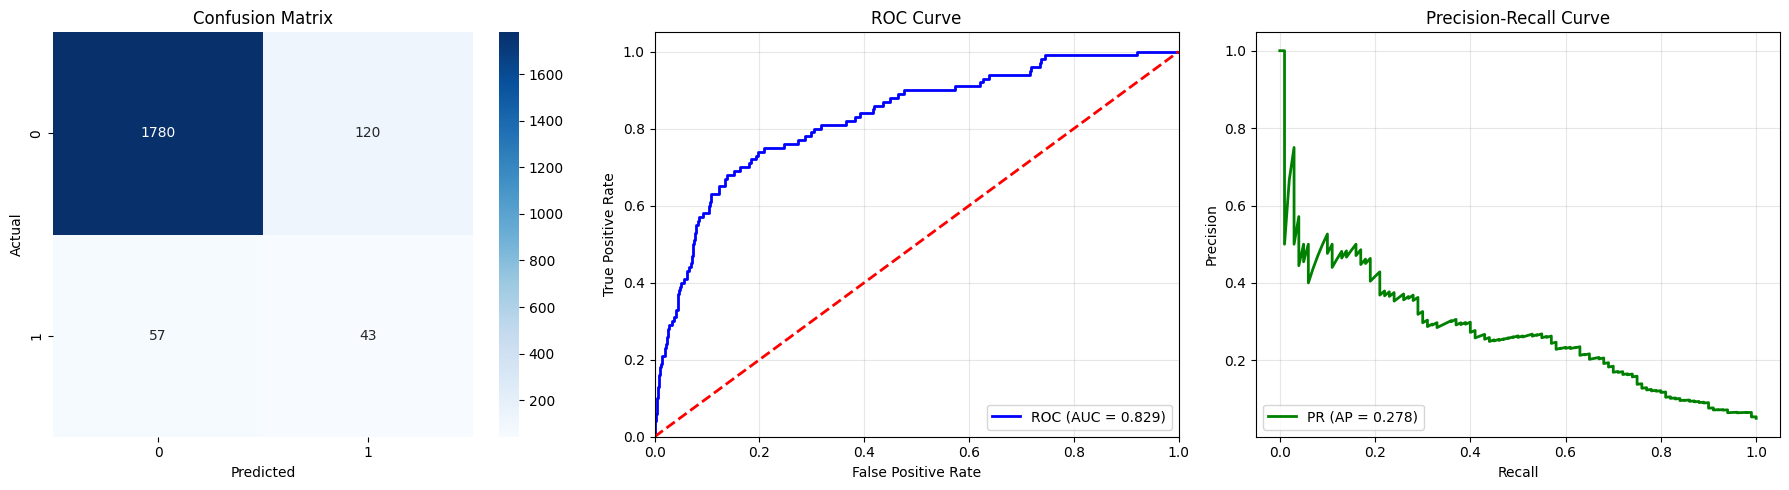


Visualizing reconstruction errors...


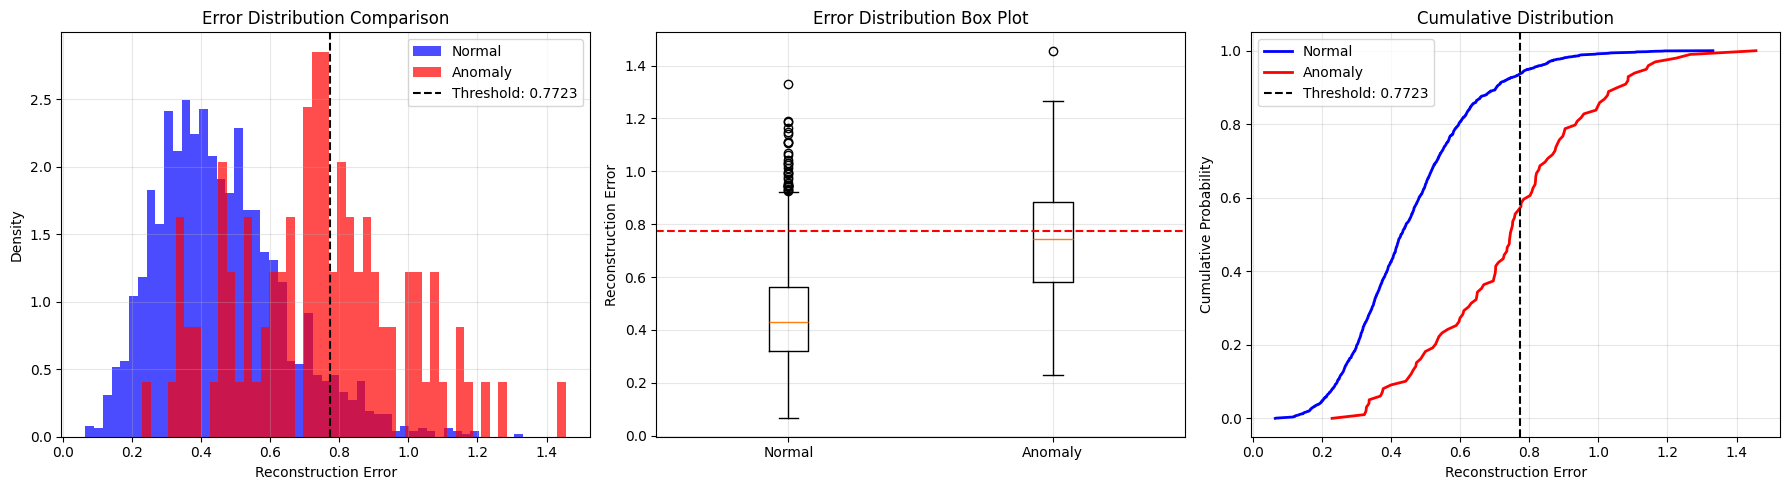


Anomaly detection analysis completed!


In [ ]:

if __name__ == "__main__":
    main()